Train shape: (3266, 5, 3) (3266, 3)
Val   shape: (1010, 5, 3) (1010, 3)
Test  shape: (1770, 5, 3) (1770, 3)


2025-12-08 17:10:30.089511: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-08 17:10:30.089665: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-08 17:10:30.089677: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-08 17:10:30.089879: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-08 17:10:30.089897: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, pref

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 32)          │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,027 (50.89 KB)

 Trainable params: 13,027 (50.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


2025-12-08 17:10:31.145584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-08 17:10:31.151200: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.



Epoch 1: val_loss improved from None to 0.55085, saving model to bestmodel.keras
103/103 - 4s - 43ms/step - loss: 0.6675 - val_loss: 0.5509
Epoch 2/100

Epoch 2: val_loss improved from 0.55085 to 0.53563, saving model to bestmodel.keras
103/103 - 2s - 19ms/step - loss: 0.5554 - val_loss: 0.5356
Epoch 3/100

Epoch 3: val_loss improved from 0.53563 to 0.52143, saving model to bestmodel.keras
103/103 - 2s - 18ms/step - loss: 0.5416 - val_loss: 0.5214
Epoch 4/100

Epoch 4: val_loss improved from 0.52143 to 0.50850, saving model to bestmodel.keras
103/103 - 2s - 17ms/step - loss: 0.5286 - val_loss: 0.5085
Epoch 5/100

Epoch 5: val_loss improved from 0.50850 to 0.49727, saving model to bestmodel.keras
103/103 - 2s - 18ms/step - loss: 0.5166 - val_loss: 0.4973
Epoch 6/100

Epoch 6: val_loss improved from 0.49727 to 0.48715, saving model to bestmodel.keras
103/103 - 2s - 17ms/step - loss: 0.5051 - val_loss: 0.4871
Epoch 7/100

Epoch 7: val_loss improved from 0.48715 to 0.47892, saving model t

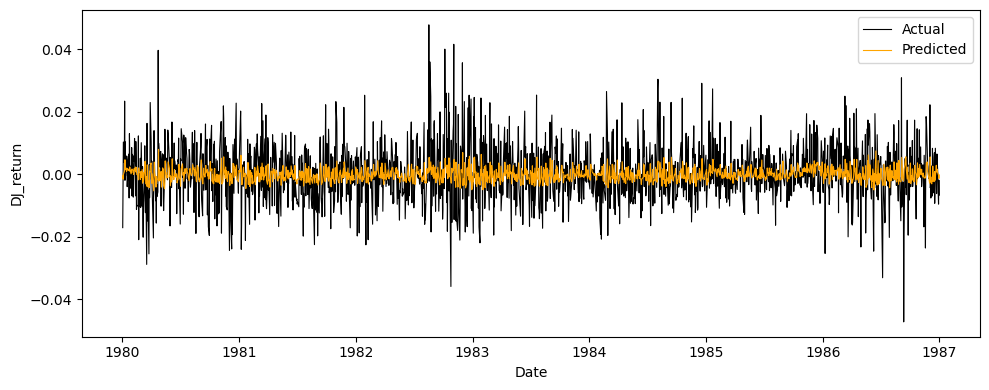

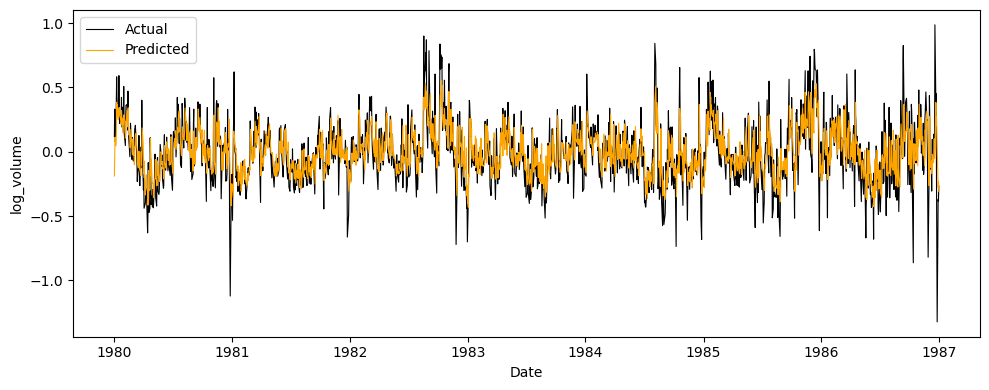

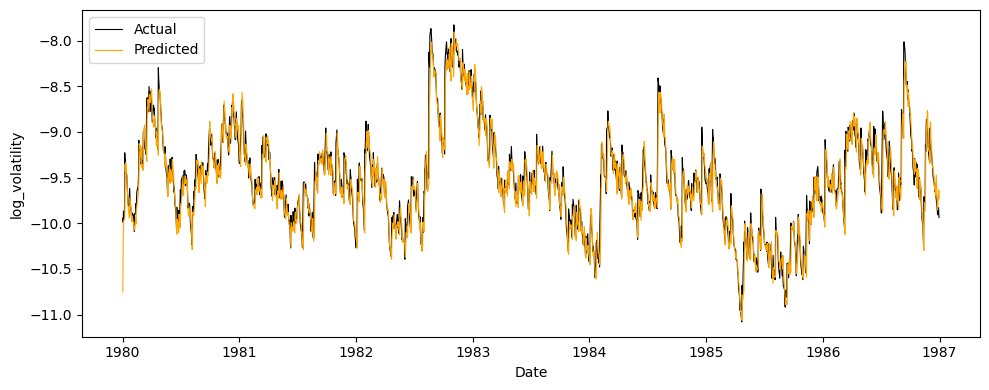

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

FILE = "Documents/Data Science for Predictive Analysis/NYSE.csv"

df = pd.read_csv(FILE, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

feature_cols = ["DJ_return", "log_volume", "log_volatility"]
target_cols = feature_cols[:]  

dates = df["date"].values
data = df[feature_cols].values.astype("float32")

train_start, train_end = pd.to_datetime("1962-12-03"), pd.to_datetime("1975-12-31")
val_start,   val_end   = pd.to_datetime("1976-01-02"), pd.to_datetime("1979-12-31")
test_start,  test_end  = pd.to_datetime("1980-01-02"), pd.to_datetime("1986-12-31")
train_mask_for_scaler = (df["date"] >= train_start) & (df["date"] <= train_end)

scaler = StandardScaler()
scaler.fit(data[train_mask_for_scaler])

data_scaled = scaler.transform(data).astype("float32")

data_orig = data.copy().astype("float32")

def create_sequences(values, date_array, window=5):
    X, y, y_dates = [], [], []
    for i in range(window, len(values)):
        X.append(values[i - window:i])  # previous 5 days
        y.append(values[i])            # next day
        y_dates.append(date_array[i])
    return np.array(X), np.array(y), np.array(y_dates)

WINDOW = 5
X_all, y_all, y_dates_all = create_sequences(data_scaled, df["date"].values, WINDOW)
train_mask = (y_dates_all >= train_start) & (y_dates_all <= train_end)
val_mask   = (y_dates_all >= val_start)   & (y_dates_all <= val_end)
test_mask  = (y_dates_all >= test_start)  & (y_dates_all <= test_end)

X_train, y_train, dates_train = X_all[train_mask], y_all[train_mask], y_dates_all[train_mask]
X_val,   y_val,   dates_val   = X_all[val_mask],   y_all[val_mask],   y_dates_all[val_mask]
X_test,  y_test,  dates_test  = X_all[test_mask],  y_all[test_mask],  y_dates_all[test_mask]

print("Train shape:", X_train.shape, y_train.shape)
print("Val   shape:", X_val.shape,   y_val.shape)
print("Test  shape:", X_test.shape,  y_test.shape)

tf.random.set_seed(42)
np.random.seed(42)

n_features = X_train.shape[2]

model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(WINDOW, n_features)),
    LSTM(32),
    Dense(len(target_cols))  # 3 outputs
])

model.compile(optimizer="adam", loss="mse")
model.summary()

checkpoint_path = "bestmodel.keras"

checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=2
)

best_model = tf.keras.models.load_model(checkpoint_path)

y_train_pred = best_model.predict(X_train)

print("\nR² on training set:")
for i, name in enumerate(target_cols):
    r2 = r2_score(y_train[:, i], y_train_pred[:, i])
    print(f"  {name}: {r2:.4f}")

y_test_pred_scaled = best_model.predict(X_test)
y_test_orig = scaler.inverse_transform(y_test)
y_test_pred_orig = scaler.inverse_transform(y_test_pred_scaled)

plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test_orig[:, 0], color="black", linewidth=0.8, label="Actual")
plt.plot(dates_test, y_test_pred_orig[:, 0], color="orange", linewidth=0.8, label="Predicted")
plt.ylabel("DJ_return")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test_orig[:, 1], color="black", linewidth=0.8, label="Actual")
plt.plot(dates_test, y_test_pred_orig[:, 1], color="orange", linewidth=0.8, label="Predicted")
plt.ylabel("log_volume")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test_orig[:, 2], color="black", linewidth=0.8, label="Actual")
plt.plot(dates_test, y_test_pred_orig[:, 2], color="orange", linewidth=0.8, label="Predicted")
plt.ylabel("log_volatility")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()
